# Processing neural time series with MNE & Python

Author : Alexandre Gramfort <alexandre.gramfort@inria.fr>

Powered by the [MNE package](http://martinos.org/mne/dev/index.html)

License : BSD 3 clause

First, load the mne package:

In [3]:
import mne

We set the log-level to 'WARNING' so the output is less verbose

In [4]:
mne.set_log_level('WARNING')

Filter warnings and import matplotlib

In [9]:
# add plot inline in the page
%matplotlib inline
import matplotlib.pyplot as plt

import warnings  # Hide all warnings here
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Access raw data

MNE gives simple access to [public datasets](http://martinos.org/mne/dev/manual/datasets_index.html)

In [10]:
from mne.datasets import spm_face
data_path = spm_face.data_path()  # downloaded automatically (approx. 2GB)
raw_fname = data_path + '/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds'
print(raw_fname)  # the path to the file

/Users/apottaba/mne_data/MNE-spm-face/MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds


Now let's read data from file:

In [11]:
raw = mne.io.read_raw_ctf(raw_fname, preload=True)
print(raw)

<RawCTF  |  SPM_CTF_MEG_example_faces1_3D.meg4, n_channels x n_times : 340 x 324474 (676.0 sec), ~842.5 MB, data loaded>


## Filtering

Band pass the data between 1Hz and 40Hz (based on `scipy.signal`)

In [12]:
raw.filter(1., 40., fir_design='firwin')

<RawCTF  |  SPM_CTF_MEG_example_faces1_3D.meg4, n_channels x n_times : 340 x 324474 (676.0 sec), ~842.5 MB, data loaded>

All metadata are stored in the `raw.info` attribute (It's Python `dict` with a nice `__repr__`)

In [13]:
raw.info

<Info | 21 non-empty fields
    bads : list | 0 items
    ch_names : list | UPPT002, UPPT001, SCLK01-177, BG1-2908, BG2-2908, ...
    chs : list | 340 items (STIM: 2, MISC: 35, REF_MEG: 29, MAG: 274)
    comps : list | 5 items
    ctf_head_t : Transform | 3 items
    custom_ref_applied : bool | False
    dev_ctf_t : Transform | 3 items
    dev_head_t : Transform | 3 items
    dig : list | 3 items
    events : list | 0 items
    highpass : float | 1.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 1 items
    lowpass : float | 40.0 Hz
    meas_date : NoneType | unspecified
    meas_id : dict | 4 items
    nchan : int | 340
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 480.0 Hz
    subject_info : dict | 1 items
    acq_pars : NoneType
    acq_stim : NoneType
    description : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneTyp

<IPython.core.display.Javascript object>


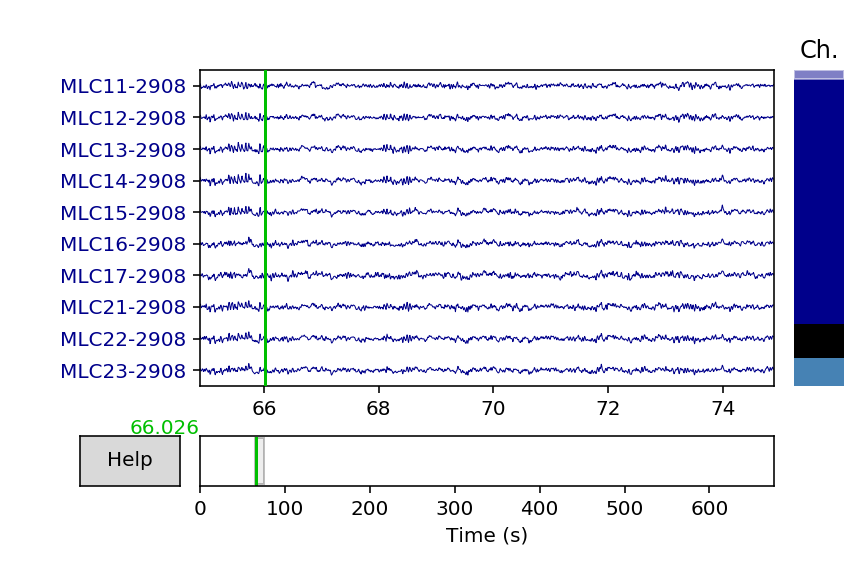

In [14]:
%matplotlib notebook
fig = raw.plot(n_channels=10)

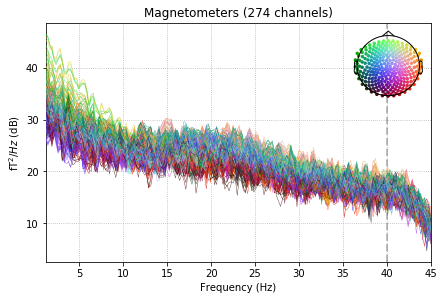

In [15]:
%matplotlib inline
raw.plot_psd(fmin=1., fmax=45., tmax=60., average=False);

## Epochs and Events

Each presentation of a stimulus corresponds to an **epoch**.

An epoch is a segment of data around the presence of an **event**.

Let's extract events from the trigger/stimulation channel:

In [16]:
events = mne.find_events(raw, stim_channel='UPPT001', verbose=True)

print(events[:5])  # just a numpy array

172 events found
Event IDs: [1 2 3]
[[2026    0    3]
 [3759    0    3]
 [5484    0    3]
 [7226    0    3]
 [8951    0    1]]


Look at the design in a graphical way:

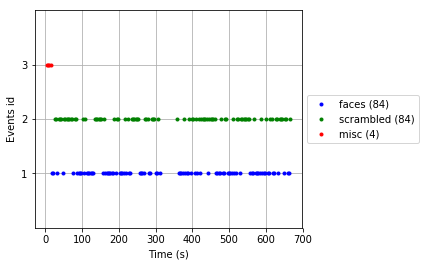

In [12]:
%matplotlib inline
event_id = {"faces": 1, "scrambled": 2, "misc": 3}
mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, event_id=event_id);

## From raw to epochs

In [13]:
event_id = {"faces": 1, "scrambled": 2}
tmin, tmax = -0.1, 0.5  # start and end of an epoch in sec.

# Set up indices of channels to include in analysis
picks = mne.pick_types(raw.info, meg=True, stim=True, eog=True,
                       ref_meg=True, exclude='bads')

# Read epochs
decim = 2  # decimate to make the example faster to run
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=None, preload=True,
                    reject=dict(mag=1.5e-12), decim=decim)

print(epochs)

<Epochs  |  n_events : 167 (all good), tmin : -0.1 (s), tmax : 0.5 (s), baseline : None, ~57.1 MB, data loaded,
 'faces': 84, 'scrambled': 83>


### Let's open the box using plain matplotlib and numpy

In [14]:
data = epochs.get_data()
print(type(data))
print(data.shape)  # n_epochs, n_channels, n_times

<class 'numpy.ndarray'>
(167, 305, 145)


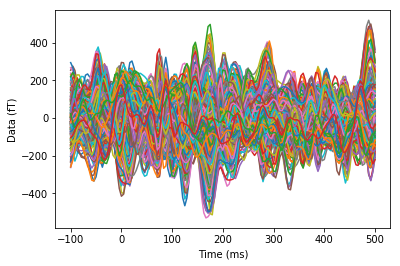

In [15]:
%matplotlib inline
plt.plot(1e3 * epochs.times, 1e15 * data[0, 31:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Data (fT)');

### Let's average all epochs to denoise

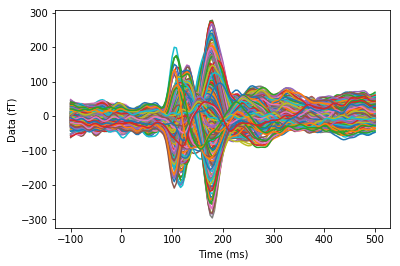

In [16]:
%matplotlib inline
import numpy as np

data_mean = np.mean(data, axis=0)

plt.plot(1e3 * epochs.times, 1e15 * data_mean[31:, :].T)
plt.xlabel('Time (ms)')
plt.ylabel('Data (fT)');

### Let's do this with MNE

The average response of the brain is called the **evoked** response.

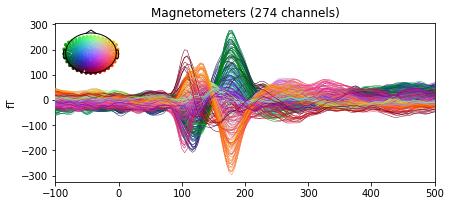

In [17]:
evoked = epochs.average()
evoked.plot(spatial_colors=True);

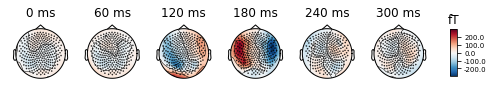

In [18]:
evoked.plot_topomap(times=np.linspace(0., 0.3, 6));

### Plot both jointly

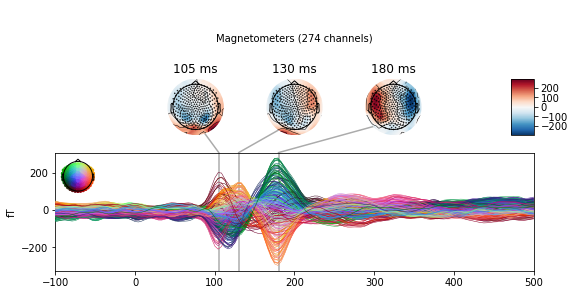

In [19]:
evoked.plot_joint(times=[0.105, 0.130, 0.180]);

### Plot interactively with ipywidgets

In [20]:
%matplotlib inline
from ipywidgets import interact
import ipywidgets as widgets

@interact(time=(evoked.times[0], evoked.times[-1], 0.01))
def plot_topo(time):
    evoked.plot_topomap(times=[time], size=3., vmin=-250., vmax=250.)

### Use Independant Component Analysis (ICA) to find latent sources in the data

In [21]:
from mne.preprocessing import ICA
ica = ICA(n_components=0.95, random_state=0).fit(epochs, decim=2)

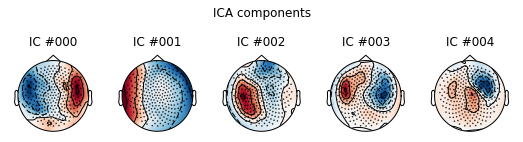

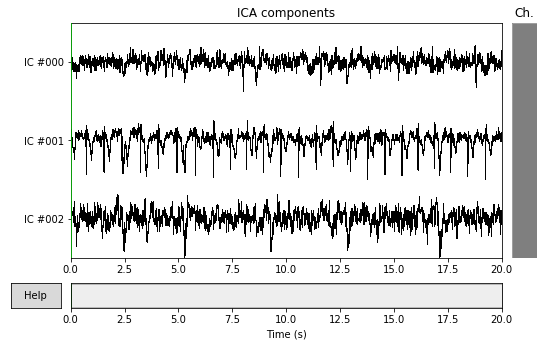

In [22]:
ica.plot_components(picks=range(5));
ica.plot_sources(raw.copy().crop(0, 20), picks=range(3));

## Where does it come from in the brain?

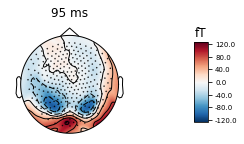

In [23]:
evoked_faces = epochs['faces'].average()
evoked_faces.plot_topomap(times=[0.095], size=2);

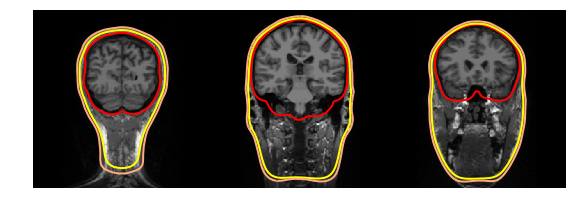

In [24]:
# Let's look the anatomy of the subject
subjects_dir = data_path + '/subjects'
mne.viz.plot_bem(subject='spm', subjects_dir=subjects_dir, slices=[50, 100, 150]);

In [25]:
# Let's look how the head fits in the system (coregistration)
fname_bem = data_path + '/subjects/spm/bem/spm-5120-5120-5120-bem-sol.fif'
fname_trans = data_path + ('/MEG/spm/SPM_CTF_MEG_example_faces1_3D_'
                           'raw-trans.fif')

`>>> mne.viz.plot_trans(evoked_faces.info,
                       fname_trans, 'spm',
                       subjects_dir,
                       ref_meg=True);`

<img src='./spm_plot_trans.png'/ width='300px'>

## We now try to explain the data with 1 dipole

Use `scipy.optimize` to find the optimal location (least square sense)

In [26]:
cov = mne.compute_covariance(epochs)  # estimate noise covariance
from sklearn.externals.joblib import Memory  # load cached result
mem = Memory(cachedir='./', verbose=0)

dipole, _ = mem.cache(mne.fit_dipole)(
                evoked_faces.copy().crop(0.095, 0.095),
                cov, fname_bem, fname_trans)
print(dipole)

<Dipole  |  n_times : 1, tmin : 0.0958333333333, tmax : 0.0958333333333>


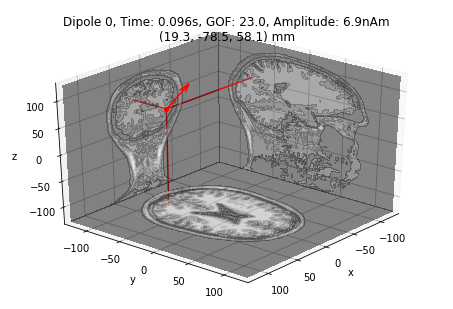

In [27]:
dipole.plot_locations(trans=fname_trans, subject='spm', subjects_dir=subjects_dir);

## MNE + scikit-learn to classify brain responses

Let's import some [scikit-learn](http://scikit-learn.org) building blocks and the rest from `
mne.decoding` module:

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from mne.decoding import SlidingEstimator, cross_val_multiscore

In [29]:
picks = mne.pick_types(epochs.info, meg=True, ref_meg=False, stim=False)
X = epochs.get_data()[:, picks]  # MEG signals: n_epochs, n_channels, n_times
y = epochs.events[:, 2]  # target: Face or Scrambled face

clf = make_pipeline(StandardScaler(), LogisticRegression())

X_2d = X.reshape(len(X), -1)
scores = cross_val_score(clf, X_2d, y, cv=5, n_jobs=1, scoring='accuracy')

# Mean scores across cross-validation splits
print("Cross-validation (Accuracy) score : %s" % np.mean(scores))

Cross-validation (Accuracy) score : 0.939906417112


Now let's do it time point by time point using MNE

In [30]:
time_decod = SlidingEstimator(clf, n_jobs=1, scoring='roc_auc')
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Mean scores across cross-validation splits for each time instant
scores = np.mean(scores, axis=0)
print(scores.shape)
print(X.shape)

(145,)
(167, 274, 145)


Then plot CV score over time.

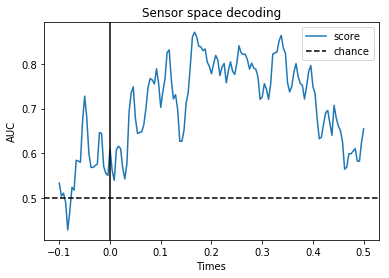

In [32]:
fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()